In [1]:
import re
import json
from pathlib import Path
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm
import pandas as pd
import zhon.hanzi

In [2]:
dyn_list = Path("../data/cbeta_dynasty.txt").read_text().strip().split("\n")
dyn_list = {dyn_x: year_x
            for dyn_x, year_x in map(lambda x: x.split(" "), dyn_list)}
cbeta_dyn_year = {dyn_x: int(year_x.split("–")[0])  # split by an en-dash
            for dyn_x, year_x in dyn_list.items()}
cbeta_cfreq = pd.read_csv("../data/cbeta.char_freq_stat.csv", index_col=0)

In [3]:
dyn_list = Path("../data/ctext_dynasty.txt").read_text().split("\n")
dyn_list = {dyn_x: year_x
            for dyn_x, year_x in map(lambda x: x.split(","), dyn_list)}
ctext_dyn_year = {dyn_x: int(year_x.split("–")[0])  # split by an en-dash
            for dyn_x, year_x in dyn_list.items()}
ctext_cfreq = pd.read_csv("../data/ctext.char_freq_stat.csv", index_col=0)

In [65]:
ctext_cfreq.sum()

ntoken    820389292
ntype        345268
dtype: int64

In [4]:
dyn_spans = [-1200, -202, 220, 618, 960, 1368, 1636, 1912]
to_intv = lambda x,y: pd.Interval(x,y,closed="left")
dyn_labels = {
    to_intv(-1200, -202): "1.先秦",
    to_intv(-202, 220): "2.漢",
    to_intv(220, 618): "3.魏晉南北",
    to_intv(618, 960): "4.唐五代十國",
    to_intv(960, 1368): "5.宋元",
    to_intv(1368, 1636): "6.明",
    to_intv(1636, 1912): "7.清",
    to_intv(1912, 2100): "8.民國"
}

span_years = {
    "1.先秦": -202,
    "2.漢": 220,
    "3.魏晉南北": 618,
    "4.唐五代十國": 960,
    "5.宋元": 1368,
    "6.明": 1636,
    "7.清": 1912,
    "8.民國": 1960
}

```
[-1200, -202)  先秦
[-202, 220) 漢
[220, 618) 魏晉南北
[618, 960) 唐五代十國
[960, 1368) 宋元
[1368, 1636) 明
[1636, 1912) 清
[1912, 2100) 民國
```

## Load data

In [27]:
cbeta_case_dir = Path("../data/case_study_body/CBETA")
cbeta_char_dfs = []
for path_x in tqdm(cbeta_case_dir.glob("**/*onegrams.tsv")):
    tgt_char = path_x.stem[0]    
    tsv_x = pd.read_table(path_x, header=None)
    tsv_x.columns = ['context', 'dyn', 'author', 'filename'] 
    tsv_x = tsv_x.drop(['context', "filename"], axis=1).groupby("dyn").count()
    tsv_x = tsv_x.assign(year=[cbeta_dyn_year[x] for x in tsv_x.index],
                         ntoken=[cbeta_cfreq.loc[x].ntoken for x in tsv_x.index])
    
    tsv_x = tsv_x\
        .groupby(pd.cut(tsv_x.year, dyn_spans, right=False))\
        .apply(lambda df_x: df_x.drop("year", axis=1).sum()/df_x.ntoken.sum())\
        .drop("ntoken", axis=1)        
    
    tsv_x = tsv_x.rename(index=dyn_labels)
    tsv_x = tsv_x.assign(target=tgt_char,
                    year=[span_years[x] for x in tsv_x.index.values])
    cbeta_char_dfs.append(tsv_x)

0it [00:00, ?it/s]

In [33]:
cbeta_chars_df = pd.concat(cbeta_char_dfs, axis=0).rename(columns={"author": "ratio"}).assign(source="cbeta")

,ratio,year
target,,
心,0.033366,6512
足,0.005070,6512
眼,0.004618,6512
頭,0.004191,6512
耳,0.003207,6512
手,0.002921,6512
口,0.002314,6512
目,0.002313,6512
首,0.002046,6512


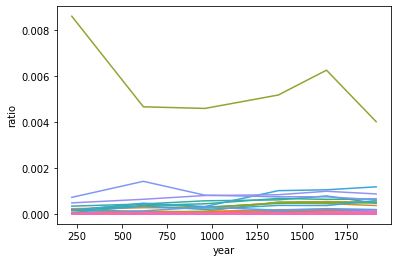

In [56]:
import matplotlib.pyplot as plt
sns.lineplot(data=cbeta_chars_df.reset_index(drop=True), x="year", y="ratio", hue="target")
plt.gca().get_legend().remove()
cbeta_chars_df.groupby("target").sum().sort_values("ratio", ascending=False)[:10]

,ratio,year
target,,
足,0.005070,6512
眼,0.004618,6512
頭,0.004191,6512
耳,0.003207,6512
手,0.002921,6512


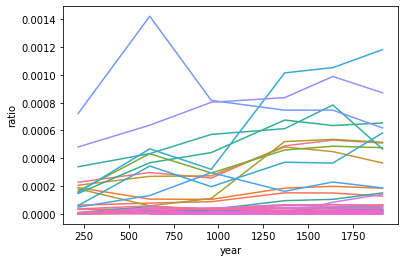

In [60]:
sns.lineplot(data=cbeta_chars_df.query("target!='心'").reset_index(drop=True), x="year", y="ratio", hue="target")
plt.gca().get_legend().remove()
cbeta_chars_df.groupby("target").sum().sort_values("ratio", ascending=False)[1:6]

## CTEXT

In [12]:
tsv_x

,target,dynasty,context
0,目,,通古今，若親＜目＞。
1,目,None,曰湄；湄，眉也，臨水如眉臨＜目＞也。
2,目,None,＜目＞，默也，默而內識也。
3,目,None,＜目＞延竦之時，諸機樞皆開張
4,目,None,鰥，昆也；昆，明也，愁挹不寐＜目＞恒鰥鰥然也。
...,...,...,...
11073,目,None,夫事人君能說主耳＜目＞，和主顏色，而獲親近，非
11074,目,None,』得鳥者一＜目＞也，今為一目之羅，無時得
11075,目,None,』得鳥者一目也，今為一＜目＞之羅，無時得鳥矣。
11076,目,None,天，萬里不逸，譬諸孺子掩＜目＞巨夫之掖，而曰逃可乎？」


In [39]:
ctext_case_dir = Path("../data/case_study_body/CTEXT")
ctext_char_dfs = []
def normalize_dynasty(dyn_text):
    if "－" in dyn_text:
        return dyn_text.split("－")[0]
    else:
        return dyn_text
        
for path_x in ctext_case_dir.glob("**/*.tsv"):
    tgt_char = path_x.stem[0]    
    tsv_x = pd.read_table(path_x, index_col=0)
    tsv_x = tsv_x.assign(dynasty=[normalize_dynasty(x) for x in tsv_x.dynasty])        
    tsv_x = tsv_x.loc[[x in ctext_dyn_year for x in tsv_x.dynasty], :]
    tsv_x = tsv_x.drop(['context'], axis=1).groupby("dynasty").count()
    tsv_x = tsv_x.assign(year=[ctext_dyn_year[x] for x in tsv_x.index],
                         ntoken=[ctext_cfreq.loc[x].ntoken for x in tsv_x.index])
    
    tsv_x = tsv_x\
        .groupby(pd.cut(tsv_x.year, dyn_spans, right=False))\
        .apply(lambda df_x: df_x.drop("year", axis=1).sum()/df_x.ntoken.sum())\
        .drop("ntoken", axis=1)        

    tsv_x = tsv_x.rename(index=dyn_labels)
    tsv_x = tsv_x.assign(target=tgt_char,
                    ratio=tsv_x.target,
                    year=[span_years[x] for x in tsv_x.index.values])
    ctext_char_dfs.append(tsv_x)    

In [40]:
ctext_chars_df = pd.concat(ctext_char_dfs, axis=0).assign(source="ctext")

In [41]:
ctext_chars_df

,target,ratio,year,source
year,,,,
1.先秦,目,0.000123,-202,ctext
2.漢,目,0.000096,220,ctext
3.魏晉南北,目,0.000084,618,ctext
4.唐五代十國,目,0.000025,960,ctext
5.宋元,目,0.000153,1368,ctext
...,...,...,...,...
3.魏晉南北,顏,0.000105,618,ctext
4.唐五代十國,顏,0.000013,960,ctext
5.宋元,顏,0.000080,1368,ctext


In [42]:
import seaborn as sns

,target,ratio,year,source
0,目,0.000123,-202,ctext
1,目,0.000096,220,ctext
2,目,0.000084,618,ctext
3,目,0.000025,960,ctext
4,目,0.000153,1368,ctext
...,...,...,...,...
317,顏,0.000105,618,ctext
318,顏,0.000013,960,ctext
319,顏,0.000080,1368,ctext
320,顏,0.000003,1636,ctext


,ratio,year
target,,
心,0.002054,6512
元,0.002017,13024
足,0.001167,6512
面,0.000849,6512
耳,0.000829,6512


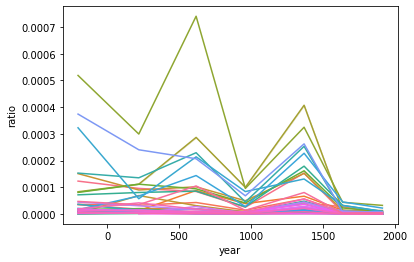

In [62]:
import matplotlib.pyplot as plt
sns.lineplot(data=ctext_chars_df.reset_index(drop=True), x="year", y="ratio", hue="target")
plt.gca().get_legend().remove()
ctext_chars_df.groupby("target").sum().sort_values("ratio", ascending=False)[:5]